# Bayesian Inference of Enzyme kinetics - Simple example

This notebook will show a basic setup for performing Bayesian inference on enzyme data to estimate kinetic parameters.
It will use the same data as shown in figure 1 of this publication: cleavage of the peptide R-AMC to AMC by the enzyme Trypsin, and inhibited by another peptide AAA-AMC.


In [1]:
# Standard scientific imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize

# Bayesian inference imports
import pymc3 as pm
import arviz as az
import theano.tensor as tt

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='notebook', font_scale=0.8);

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-01-11 11:24:12

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.28.0

arviz     : 0.11.4
pandas    : 1.2.4
matplotlib: 3.4.2
seaborn   : 0.11.1
numpy     : 1.20.3
scipy     : 1.6.2
theano    : 1.1.2
pymc3     : 3.11.4
sys       : 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]



## Data import

Steady-state data obtained from a CSTR flow reactor at different substrate (and inhibitor) input concentrations is obtained and stored in `csv` files.
In these files, every row corresponds to a unique observation, and for every observation, the experimental parameters are written alongside the observations.
So, for the Trypsin data (`CEKS33.csv`), the datafile has 3 columns: R-AMC input concentration (`R`), AAA-AMC input concentration (`AAA`), and observed AMC output concentration (`AMC`).

Two other experimental parameters relevant for the analysis are the flowrate $k_f$ and the enzyme concentration $E$.
While in this case, they are the same for the full experimental dataset, this doesn't need to be the case.
Here, we add them as additional columns to the dataset after loading in the `csv` file.

In the below two cells, we load in the data and show the resulting Pandas Dataframe, and we plot the data using Seaborn.

In [2]:
data = pd.read_csv("../data/CEKS33.csv")
kf = 0.125  # minute^-1
E = 0.012 
data = data.assign(kf=kf, Tr=E)
data

,R,AAA,AMC,kf,Tr
0,50,0,2.609888,0.125,0.012
1,100,0,4.265064,0.125,0.012
2,200,0,6.197783,0.125,0.012
3,300,0,7.167780,0.125,0.012
4,500,0,7.681850,0.125,0.012
5,50,1500,2.501800,0.125,0.012
6,100,1500,3.882780,0.125,0.012
7,200,1500,5.150944,0.125,0.012
8,300,1500,5.629337,0.125,0.012
9,500,1500,5.961178,0.125,0.012


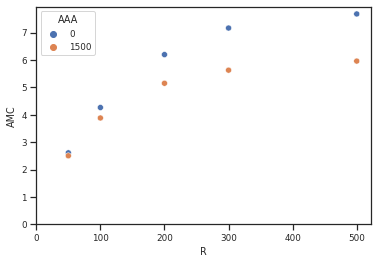

In [3]:
sns.scatterplot(data=data, x="R", y='AMC', hue='AAA', palette='deep')
plt.xlim(0)
plt.ylim(0)
plt.show()

## Model definition

Next, we create a probabilistic model for the steady-state concentrations using PyMC3. 
For a single substrate enzyme this is relatively simple, and only requires rewriting of the ODE's associated to the system.

### Rewriting the ODE's
In the case of R-AMC cleavage by Trypsin, inhibited by AAA-AMC, the system of ODE's is as follows:

$$\frac{dS}{dt} = \frac{-k_{cat}ES}{K_M + S*(1+I/K_I)} + k_f\cdot (S_{in} - S) $$
$$\frac{dP}{dt} = \frac{k_{cat}ES}{K_M + S*(1+I/K_I)} - k_f\cdot P $$

Here, $S$ is the substrate concentration inside the CSTR, $P$ the product concentration inside the CSTR, and $I$ the inhibitor concentration. 
Flow in to and out of the reactor is accounted for by inclusion of the flow-terms $k_f\cdot (...)$.

As we only observe our system in steady-state ($dP/dt = dS/dt = 0$), this can be implicitly written as:

$$P_{ss} =  \frac{k_{cat}ES_{ss}}{k_f*(K_M + S_{ss}*(1+I/K_I))}$$

or rewritten expliticly using $S_{ss} = S_{in} - P_{ss}$ (which follows from mass conservation):

$$P_{ss} = 0.5(k_{cat}E/\alpha*k_f + K_M/\alpha + S_{in}) - 0.5\sqrt{(k_{cat}E/\alpha*k_f + K_M/\alpha)+ S_{in})^2-4S_{in}k_{cat}E/\alpha*k_f} $$

where we have rewritten the inhibition factor as $\alpha = 1 + I/K_I$.
However, the implicit version can be used during Bayesian inference, and is often easier to write down (and less susceptible to mistakes) than the explicit version.

### Stating the likelihood and priors
We know $S_{in}$ and observe corresponding $P_{ss}$ (including noise), so we can infere the parameters $k_{cat}$, $K_M$ and $K_I$ from this data.
We can do this by writing down the likelihood function $P(y|\phi)$, giving the probability of observing the data, given specific values of the kinetic parameters, generally indicated as:
 $$\mathcal{L}(y, \phi)$$
where $y$ denotes the observed data and $\phi$ the parameters to be inferred.
In the case of observations of steady-state, we assume that our observations $P_{obs}$ are normally-distributed with some noise $\sigma$ around the expected value $P_{ss}(S_{in}, k_f, E; K_M, k_{cat}, K_I):
$$\mathcal{L}(y, \phi) = P(P_{obs}|S_{in}, k_f, E; K_M, k_{cat}, K_I) = \mathcal{N}(P_{ss}(S_{in}, k_f, E; K_M, k_{cat}, K_I), \sigma) $$
 where the experimental parameters $S_{in}$, $k_f$ and $E$ are known beforehand, and the kinetic parameters $K_M$ and $k_{cat}$ are unknown.

*A priori* we only know that both kinetic parameters should be positive-definite.
We include this prior knowledge by assuming that these kinetic parameters have a uniformally distributed probability of having a value between 0 and some high maximum boundary (setting this boundary too low will cause estimation problems, because the correct values are then never sampled).
This is an example of an uninformative distribution, which ensures that the sampler can converge, without adding subjective information to the model.
These priors are indicated as $P(K_M)$, $P(k_{cat})$ and $P(K_I)$.
If more knowledge is available about the values of the kinetic parameters, than this knowledge can be used in the analysis by changing the appropriate priors.

Similar to the kinetic parameters, the experimental noise (or more generally, the observational uncertainty) is unknown.
Therefore, we also use a prior for this value.
This prior generally has an exponential distribution (a particular case of the gamma distribution), which ensures good convergence while remaining uninformative.

Both the *likelihood* and the *priors* are modelled using PyMC3, which also takes care of assembling these probabilities together using Bayes' Theorem, and sampling the probabilistic model to obtain parameter estimates using a Hamiltonian Monte Carlo algorithm.
Applying Bayes' Theorem to the priors and likelihood finally results in the expression:

$$P(k_{cat},K_M,K_I,\sigma | P_{obs}; S_{in}, k_f, E ) \propto P(k_{cat})\cdot P(K_M)\cdot P(K_I)\cdot P(\sigma)\cdot P(P_{obs}|S_{in}, k_f, E; K_M, k_{cat}, K_I)$$

This is shown in the cell below.


In [4]:
with pm.Model() as model:
    # Stating the priors
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_M = pm.Uniform("K_M", 0, 500)
    K_I = pm.Uniform("K_I", 1000, 10000)
    sigma = pm.Exponential("sigma", 10)

    # We extract all data from the dataframe here so the likelihood is easier to write down
    S_in = data["R"].values
    I_in = data["AAA"].values
    P_obs = data["AMC"].values
    S_obs = S_in - P_obs # Substrate concentration inside reactor determined via stoichiometric conservation at steady-state
    E = data["Tr"].values
    kf = data["kf"].values

    # Inference of probabilistic model at steady-state conditions
    P = pm.Normal(
        "obs", 
        mu=k_cat * E * S_obs / (kf * (K_M + S_obs*(1+I_in/K_I))), 
        sigma=sigma, 
        observed=P_obs
    )

## Visualizing the probabilistic model

After composing the model, we can visualize it using graphviz (a built-in function in PyMC3).
This graph shows the relationship between the variables which are to be inferred, and the observations that have been made.
In the case of this simple model, these relationships are rather straightforward, but this is a useful tool to inspect more complex models based on multiple datasets.

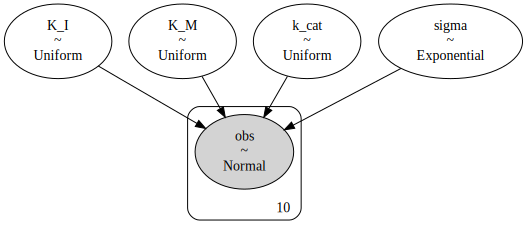

In [5]:
pm.model_to_graphviz(model)

## Sampling of the model

After creating the probabilistic model, we can use Monte-Carlo sampling to obtain the posterior probability distribution $P(k_{cat},K_M,K_I,\sigma | P_{obs}; S_{in}, k_f, E)$.
This distribution is obtained as an InferenceData object, which stores meta-information about the priors, data, and sampling, alongside the sampling traces from which the distribution is build.

In [6]:
with model:
    idata = pm.sample(
        1000,
        tune=1000,
        cores=8,
        step=pm.NUTS(target_accept=0.95),
        return_inferencedata=True,
    )

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, K_I, K_M, k_cat]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


## Analyzing the posterior

The posterior is obtained as a trace of samples drawn from the posterior distribution, where samples are simultaneously drawn from all inferrable parameters.

This posterior can then be used for a variety of analysis tasks, such as plotting the full probability distributions of single parameters, or the correlated probability distribution of two parameters.
By calculating the mean or specific quantiles of the parameters, specific statistics can be obtained, such as the mean parameter value, the 95% probability (or confidence) interval, or the most likely parameter value (the mode of the distribution).

The Arviz package can be used for quick visualizations of various statistical properties.

In [11]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

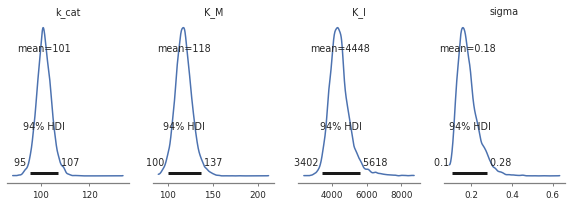

In [7]:
with model:
    az.plot_posterior(idata, figsize=(10,3))

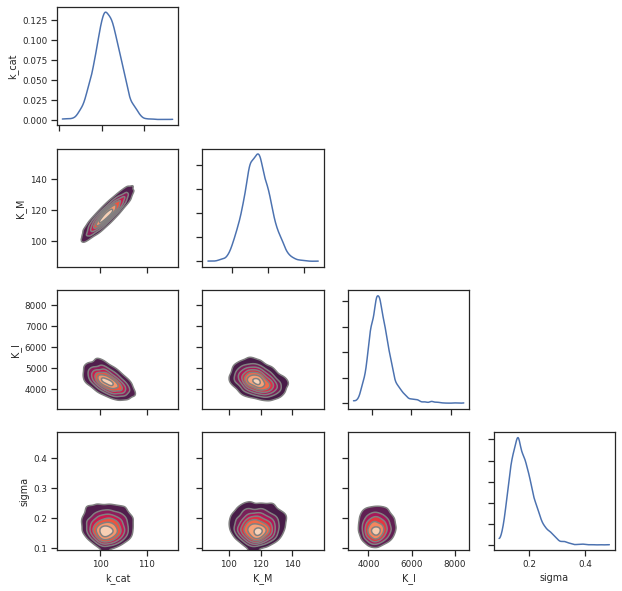

In [19]:
with model:
    az.plot_pair(idata, marginals=True, kind='kde', divergences=True, figsize=(10,10))

## Analyzing the experimental uncertainty

In addition to analysing the posterior distributions, we can also use the resulting InferenceData to evaluate the experimental uncertainty in our data.
We do this by sampling from the posterior predictive distribution $$P(P_{ss} | k_{cat},K_M,K_I,\sigma; P_{obs}; S_{in}, k_f, E )$$
which uses the parameter estimates obtaind by the posterior distribution to predict the probability of observing specific product concentrations at specific experimental conditions, taking into account all of the observations that have already been done.
Using the previous experimental conditions for this, we can compare the experimental uncertainty $\sigma$ present in a dataset, relative to the actual observed values.

This is shown in the plot below, where we plot the observations (the dots), alongside the posterior predictive distributions at the same experimental conditions of those observations. 
Thus, these distributions show us the probability of observing specific values. 
For experiments with little uncertainty, the posterior predictive should be roughly Normal-distributed with little variance, and with the actual observations corresponding to unbiased samples from those distributions.
A large variance, or a bias in observations compared to posterior predictive distributions, is an indication of an experimental dataset with large uncertainty.

For the single experiment shown in this example, this analysis is not so relevant.
But when combining many different datasets together, the uncertainty estimates act as a natural, objective weighting of the observations, and reveals which experiments (relative to all other experiments) have a large uncertainty associated with them.


In [53]:
with model:
    post_pred = pm.sample_posterior_predictive(idata, var_names=["obs"])

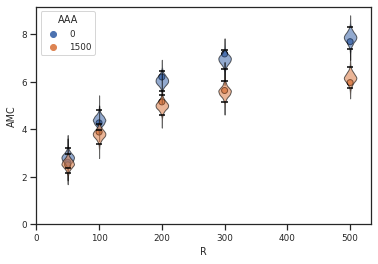

In [54]:
scat = sns.scatterplot(data=data, x="R", y='AMC', hue='AAA', palette='deep', edgecolor='black', linewidth=1)

mask_1 = data.AAA == 0
part1_N = len(data[mask_1])
violin_parts = plt.violinplot(post_pred["obs"][:,mask_1], positions=data[mask_1].R, 
showextrema=False, widths=20, quantiles=[[0.025, 0.975]]*part1_N, points=100)
for pc in violin_parts['bodies']:
    pc.set_facecolor('C0')
    pc.set_alpha(0.6)
    pc.set_edgecolor('black')
violin_parts['cquantiles'].set_colors("black")

mask_2 = data.AAA != 0
part2_N = len(data[mask_2])
violin_parts = plt.violinplot(post_pred["obs"][:,mask_2], positions=data[mask_2].R, 
showextrema=False, widths=20, quantiles=[[0.025, 0.975]]*part2_N, points=100)
for pc in violin_parts['bodies']:
    pc.set_facecolor('C1')
    pc.set_alpha(0.6)
    pc.set_edgecolor('black')
violin_parts['cquantiles'].set_colors("black")

plt.xlim(0)
plt.ylim(0)
plt.show()